In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install timm

# Project

# Librerias

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import concurrent.futures
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import glob
import scipy.io

from google.colab import drive

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

# Cargar Datos

Primero es necesario cargar las imagenes y la cantidad de personas que aparecen en cada una de ellas. Esta cantidad esta contenida en un archivo .csv que contiene el nombre de la imagen y la cantidad de cabezas que se ven en la imagen.
Como no todas las imagenes del dataset estan incluidas en este archivo, solo se cargarán las que si lo están.

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ProyectoFinal/Group Counting/archive/train.csv')

In [ ]:
df.head()

,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4


In [ ]:
#Utilizando el nombre se cargan las imagenes
directorio_imagen = '/content/gdrive/MyDrive/Colab Notebooks/ProyectoFinal/Group Counting/archive/image_data'

def cargar_imagen(nombre_imagen):
    ruta_imagen = os.path.join(directorio_imagen, nombre_imagen)
    if os.path.exists(ruta_imagen):
        imagen = load_img(ruta_imagen)
        imagen_array = img_to_array(imagen)
        imagen_array = imagen_array / 255.0
        return imagen_array
    else:
        print(nombre_imagen, ' no añadida')
        return None

with concurrent.futures.ThreadPoolExecutor() as executor:
    df['imagen'] = list(executor.map(cargar_imagen, df['Name']))

In [ ]:
df.head()

,Name,HeadCount,imagen
0,10001.jpg,4,"[[[1.0, 0.98039216, 1.0], [0.972549, 0.9529412..."
1,10002.jpg,4,"[[[0.85882354, 0.8509804, 0.7921569], [0.86666..."
2,10003.jpg,2,"[[[0.30980393, 0.28235295, 0.21176471], [0.325..."
3,10004.jpg,3,"[[[0.38431373, 0.50980395, 0.65882355], [0.384..."
4,10006.jpg,4,"[[[0.9098039, 0.9372549, 0.9607843], [0.909803..."


La columna "Name" ya no tiene ninguna utilidad por lo que se puede eliminar

In [ ]:
df = df.drop('Name', axis=1)

In [ ]:
df.head()

,HeadCount,imagen
0,4,"[[[1.0, 0.98039216, 1.0], [0.972549, 0.9529412..."
1,4,"[[[0.85882354, 0.8509804, 0.7921569], [0.86666..."
2,2,"[[[0.30980393, 0.28235295, 0.21176471], [0.325..."
3,3,"[[[0.38431373, 0.50980395, 0.65882355], [0.384..."
4,4,"[[[0.9098039, 0.9372549, 0.9607843], [0.909803..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   HeadCount  5733 non-null   int64 
 1   imagen     5733 non-null   object
dtypes: int64(1), object(1)
memory usage: 89.7+ KB


Como los datos se cargaron a partir de los nombres de las columnas se asume que no hay valores duplicados

In [ ]:
# Obtener imagenes para verificar el correcto funcionamiento del dataframe
random = df.sample(9)

plt.figure(figsize=(10, 10))
for i, (_, row) in enumerate(random.iterrows()):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(row['imagen'])
    plt.title(row['HeadCount'])
    plt.suptitle('Imagenes aleatorias')
    plt.axis('off')

# CNN

Para poder definir y entrenar un modelo primero procedo a dividir el df en conjjuntos de train, validation y test

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

In [ ]:
# Elimina el índice en los conjuntos de entrenamiento, validación y prueba
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [ ]:
X_train_np = df_train['imagen']
X_val_np = df_val['imagen']
X_test_np = df_test['imagen']

y_train_np = df_train['HeadCount'].values
y_val_np = df_val['HeadCount'].values
y_test_np = df_test['HeadCount'].values


Para optimizar los tiempos de entrenamiento se pasan los conjuntos a tensores

In [ ]:
#Para poder trabajar con imagenes de diferentes tamaños debo crear tensores por separado y luego unirlos

def crear_tensor_mitad(imagen):
    # Redimensionar las imágenes a la mitad porque no hay suficiente memoria para tratar este volumen de datos
    imagenes_reducidas = [tf.image.resize(img, [tf.shape(img)[0] // 2, tf.shape(img)[1] // 2]) for img in imagen]

    # Convertir la lista de imágenes redimensionadas a tensores
    tensor_list = [tf.convert_to_tensor(img, dtype=tf.float32) for img in imagenes_reducidas]

    # Obtener la forma de cada imagen redimensionada
    shapes_reducidas = [tf.shape(img) for img in tensor_list]

    # Encontrar la forma máxima entre todas las imágenes redimensionadas
    max_shape_reducida = tf.reduce_max(shapes_reducidas, axis=0)

    # Rellenar todas las imágenes redimensionadas para que tengan la forma máxima
    padded_images_reducidas = [tf.image.pad_to_bounding_box(img, 0, 0, max_shape_reducida[0], max_shape_reducida[1]) for img in tensor_list]

    # Convertir la lista de imágenes rellenadas a un tensor
    stacked_tensor_reducida = tf.stack(padded_images_reducidas, axis=0)

    # Crear un tf.RaggedTensor a partir del tensor apilado
    ragged_tensor_reducida = tf.RaggedTensor.from_tensor(stacked_tensor_reducida)

    dense_tensor = ragged_tensor_reducida.to_tensor()

    return dense_tensor

In [ ]:
X_train = crear_tensor_mitad(X_train_np)
X_val = crear_tensor_mitad(X_val_np)
X_test = crear_tensor_mitad(X_test_np)

In [ ]:
y_train = tf.convert_to_tensor(y_train_np, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val_np, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test_np, dtype=tf.float32)

Ahora defino un modelo

In [ ]:
cnn_model = tf.keras.Sequential([
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2), #2,2 es el tamaño de la matriz de agrupación

    Dropout(0.1),

    Conv2D(32, (3,3), activation='relu'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2), #2,2 es el tamaño de la matriz de agrupación

    Dropout(0.1),

    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(1, activation='linear')
])

In [ ]:
# Para conteo de datos es muy efectiva la funcion de perdida tf.keras.losses.Poisson()
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=tf.keras.losses.Poisson(),
                  metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

cnn_results = cnn_model.fit(X_train, y_train, epochs=20, batch_size=64,
                      validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/20
61/61 [==============================] - 392s 6s/step - loss: -2.1265 - accuracy: 0.0080 - val_loss: -1.8942 - val_accuracy: 0.0092
Epoch 2/20
61/61 [==============================] - 386s 6s/step - loss: -2.2088 - accuracy: 0.0082 - val_loss: -1.8711 - val_accuracy: 0.0092
Epoch 3/20
61/61 [==============================] - 388s 6s/step - loss: -2.2319 - accuracy: 0.0082 - val_loss: -1.9011 - val_accuracy: 0.0092
Epoch 4/20
61/61 [==============================] - 389s 6s/step - loss: -2.2499 - accuracy: 0.0082 - val_loss: -1.8558 - val_accuracy: 0.0092
Epoch 5/20
61/61 [==============================] - 387s 6s/step - loss: -2.2773 - accuracy: 0.0074 - val_loss: -1.9356 - val_accuracy: 0.0092
Epoch 6/20
61/61 [==============================] - 387s 6s/step - loss: -2.2874 - accuracy: 0.0074 - val_loss: -1.7992 - val_accuracy: 0.0092
Epoch 7/20
61/61 [==============================] - 386s 6s/step - loss: -2.3288 - accuracy: 0.0074 - val_loss: -1.8269 - val_accuracy: 0.0092

In [ ]:
cnn_model = tf.keras.Sequential([
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2), #2,2 es el tamaño de la matriz de agrupación

    Dropout(0.5),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2), #2,2 es el tamaño de la matriz de agrupación

    Dropout(0.5),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2), #2,2 es el tamaño de la matriz de agrupación

    Dropout(0.5),

    Flatten(),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='linear')
])

In [ ]:
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=tf.keras.losses.Poisson(),
                  metrics=['accuracy'])

In [ ]:
cnn_results = cnn_model.fit(X_train, y_train, epochs=20, batch_size=64,
                      validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/20
61/61 [==============================] - 504s 8s/step - loss: nan - accuracy: 0.0041 - val_loss: 4.4003 - val_accuracy: 0.0092
Epoch 2/20
61/61 [==============================] - 516s 8s/step - loss: nan - accuracy: 0.0028 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/20
61/61 [==============================] - 518s 9s/step - loss: nan - accuracy: 0.0046 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/20
61/61 [==============================] - 541s 9s/step - loss: nan - accuracy: 0.0036 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/20
61/61 [==============================] - 512s 8s/step - loss: nan - accuracy: 0.0033 - val_loss: nan - val_accuracy: 0.0092
Epoch 6/20
61/61 [==============================] - 500s 8s/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0072
Epoch 7/20
61/61 [==============================] - 528s 9s/step - loss: nan - accuracy: 0.0049 - val_loss: nan - val_accuracy: 0.0092
Epoch 8/20
61/61 [======================

# Transfer learning

No se obtienen resultados resultados aceptables. Para podemor mejorar los resultados se va a utilizar DetrForObjectDetection y un modelo ya entrenado

In [ ]:
from transformers import pipeline

model = pipeline("object-detection")

No model was supplied, defaulted to facebook/detr-resnet-50 and revision 2729413 (https://huggingface.co/facebook/detr-resnet-50).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


## Imagenes de grupos

In [ ]:
def cantidad_personas(lista):
    personas = 0
    for elem in lista:
        if elem.get('label')=='person':
            personas += 1
    return personas

def imprimir_objetos(img, lista):
    plt.imshow(img.values[0])
    for elem in lista:
        if elem.get('label')=='person':
            width = elem['box']['xmax'] - elem['box']['xmin']
            height = elem['box']['ymax'] - elem['box']['ymin']
            rect = patches.Rectangle((elem['box']['xmin'], elem['box']['ymin']), width, height, linewidth=5, edgecolor='r', facecolor='none')

            plt.gca().add_patch(rect)

    plt.title(f'Cantidad de personas: {cantidad_personas(lista)}', fontsize=60)
    plt.axis('off')

def array_to_image(array):
    return Image.fromarray((array * 255).astype('uint8'))

In [ ]:
random = df.sample(1)
imagen_array = random['imagen'].values[0]
imagen_pil = array_to_image(imagen_array)

ev_modelo = model(imagen_pil)

cantidad = cantidad_personas(ev_modelo)

print(f"Cantidad de personas: {cantidad}")

print(ev_modelo)

plt.figure(figsize=(25, 25))
imprimir_objetos(random['imagen'], ev_modelo)

In [ ]:
def imprimir_objetos_multiple(img, lista):
    plt.imshow(img)
    for elem in lista:
        if elem.get('label')=='person':
            width = elem['box']['xmax'] - elem['box']['xmin']
            height = elem['box']['ymax'] - elem['box']['ymin']
            rect = patches.Rectangle((elem['box']['xmin'], elem['box']['ymin']), width, height, linewidth=0.5, edgecolor='r', facecolor='none')

            plt.gca().add_patch(rect)

    plt.title(f'Cantidad de personas: {cantidad_personas(lista)}')
    plt.axis('off')

In [ ]:
# Ahora lo pruebo con diversas imagenes del df
random = df.sample(9)

plt.figure(figsize=(10, 10))
for i, (_, row) in enumerate(random.iterrows()):
    ax = plt.subplot(3, 3, i + 1)
    imagen_array = row['imagen']
    imagen_pil = array_to_image(imagen_array)
    ev_modelo = model(imagen_pil)
    imprimir_objetos_multiple(row['imagen'], ev_modelo)

Al ser un modelo que detecta objetos en algunos momentos puede generar algunos errores pero en general parece funcionar de forma bastante correcta

## Imagenes de multitudes

Ahora lo voy a poner a prueba con imagenes de multitudes obtenidas originalmente de kaggle del dataset ShangaiTech https://www.kaggle.com/datasets/tthien/shanghaitech

In [ ]:
#Importo algunas imagenes de multitudes
df_crowd = tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/Colab Notebooks/ProyectoFinal/Crowd Counting/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/', shuffle=False)

Found 300 files belonging to 1 classes.


In [ ]:
#La información de la cantidad de personas que se encuentra en cada foto esta almacenada en archivos .mat

# Patrón para seleccionar todos los archivos .mat en el directorio
mat_files = glob.glob(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/ProyectoFinal/Crowd Counting/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth', '*.mat'))

# Ordenar la lista de archivos
mat_files_sorted = sorted(mat_files)

# Lista para almacenar los datos cargados
data_list = []

# Iterar sobre los archivos .mat de train y cargarlos
for mat_file in mat_files_sorted:
    mat_data = scipy.io.loadmat(mat_file)
    data_list.append(mat_data)

In [ ]:
image_info_df = []
for data in data_list:
    image_info = data["image_info"]
    image_info_df.append(image_info)

In [ ]:
number_list = np. array([])
for image in image_info_df:
    number_array = image[0,0][0][0][1]
    number = number_array[0][0]
    number_list = np.append(number_list, number)
number_list = number_list.astype(int)

In [ ]:
# Se muestran algunas imagenes con la cantidad de personas que la componen
plt.figure(figsize=(7, 7))
for images, labels in df_crowd.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(number_list[i])
        plt.axis('off')

Para poder utilizar las funciones ya definidas tengo que transformar al mismo formato de df las imagenes de multitudes

In [ ]:
# Con esto df_crowd_pd es un DataFrame de pandas con una columna 'imagen' que contiene arrays de NumPy
# y una columna 'HeadCount' que contiene las etiquetas correspondientes

imagenes = []

for imagenes_batch, etiquetas_batch in df_crowd:
    imagenes.extend(imagenes_batch.numpy())

df_crowd_pd = pd.DataFrame({'imagen': imagenes})

df_crowd_pd['HeadCount'] = pd.DataFrame(number_list) #La información de la cantidad de personas ya la tengo de number_list

In [ ]:
df_crowd_pd.head()

,imagen,HeadCount
0,"[[[251.0, 250.0, 254.0], [207.0, 206.0, 211.5]...",1546
1,"[[[44.416992, 58.918945, 68.418945], [78.64258...",920
2,"[[[251.0, 253.0, 252.0], [241.5, 245.5, 246.5]...",371
3,"[[[39.0, 52.0, 34.0], [35.5, 48.5, 30.5], [43....",298
4,"[[[130.5, 104.5, 115.5], [136.5, 110.5, 121.5]...",184


In [ ]:
# Se enseñan 9 imagenes al azar para verificar el correcto funcionamiento del dataframe
random = df_crowd_pd.sample(9)

random['imagen'] = random['imagen'] / 255.0

plt.figure(figsize=(10, 10))
for i, (_, row) in enumerate(random.iterrows()):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(row['imagen'])
    plt.title(row['HeadCount'])
    plt.suptitle('Imagenes aleatorias')
    plt.axis('off')

In [ ]:
def imprimir_multitud_multiple(data, lista):
    img = data['imagen']
    plt.imshow(img)
    for elem in lista:
        if elem.get('label')=='person':
            width = elem['box']['xmax'] - elem['box']['xmin']
            height = elem['box']['ymax'] - elem['box']['ymin']
            rect = patches.Rectangle((elem['box']['xmin'], elem['box']['ymin']), width, height, linewidth=0.5, edgecolor='r', facecolor='none')

            plt.gca().add_patch(rect)

    title = f'Cantidad de personas calculada: {cantidad_personas(lista)}\n'
    title += f'Cantidad de personas real: {data["HeadCount"]}'
    plt.title(title, fontsize=10)
    plt.axis('off')

In [ ]:
random = df_crowd_pd.sample(9)

random['imagen'] = random['imagen'] / 255.0

plt.figure(figsize=(10, 10))
for i, (_, row) in enumerate(random.iterrows()):
    ax = plt.subplot(3, 3, i + 1)
    imagen_array = row['imagen']
    imagen_pil = array_to_image(imagen_array)
    ev_modelo = model(imagen_pil)
    imprimir_multitud_multiple(row, ev_modelo)

Como se puede ver el resultado obtenido no es el esperado. Para intentar mejorarlo se va a proceder a dividir una imagen en varios trozos y a evaluar uno por uno

In [ ]:
def dividir_imagen(img, size=(50, 50)):
    # Obtiene el tamaño de la imagen
    width, height = img.size

    # Tamaño de los trozos
    trozo_width, trozo_height = size

    # Calcula la cantidad de trozos a lo largo de x e y
    trozos_x = width // trozo_width
    trozos_y = height // trozo_height

    # Lista para almacenar los trozos
    trozos = []

    # Itera sobre los trozos y agrégalos a la lista
    for j in range(trozos_y):
        for i in range(trozos_x):
            xmin, ymin = i * trozo_width, j * trozo_height
            xmax, ymax = xmin + trozo_width, ymin + trozo_height
            trozo = img.crop((xmin, ymin, xmax, ymax))
            trozos.append(trozo)

    return trozos

In [ ]:
# Para hacer esta prueba selecciono una imagen en especifico en onde se identifiquen claramente las caras de las personas

# Imagen que se desea dividir
imagen_crowd = Image.fromarray(df_crowd_pd['imagen'][5].astype('uint8'))

# Tamaño de los trozos
tamaño_trozos = (50, 50)

# Obtiene los trozos de la imagen
trozos = dividir_imagen(imagen_crowd, tamaño_trozos)

# Muestra cada trozo individualmente
for i, trozo in enumerate(trozos):
    trozo.show()

In [ ]:
filas = int(np.ceil(np.sqrt(len(trozos))))
columnas = int(np.ceil(len(trozos) / filas))

# Muestra todos los trozos en una sola imagen
plt.figure(figsize=(10, 10))

for i, trozo in enumerate(trozos, 1):
    plt.subplot(filas, columnas, i)
    plt.imshow(np.array(trozo))
    plt.axis('off')

plt.show()

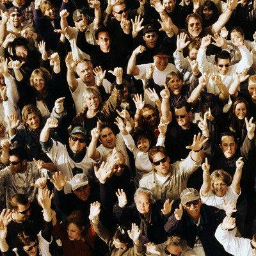

In [ ]:
imagen_crowd

In [ ]:
# Ahora aplico el modelo a cada trozo y se muestra el conteo de las personas localizadas

filas = int(np.ceil(np.sqrt(len(trozos))))
columnas = int(np.ceil(len(trozos) / filas))

plt.figure(figsize=(15, 15))
for i, trozo in enumerate(trozos, 1):
    ax = plt.subplot(filas, columnas, i)
    ev_modelo = model(trozo)
    imprimir_objetos_multiple(trozo, ev_modelo)

Como se puede apreciar no ha sido detectada ninguna persona. El problema puede venir de la calidad de la imagen. Para reducir el consumo de memoria las imagenes se importaron de forma automatica, sin especificar el tamaño, por lo que fueron reducidas a 256x256

Se va a volver a realizar la prueba con otra foto de mayor calidad, tanto descargandola en 256x256 como en su resolución real

In [ ]:
# Imagen que se desea dividir
imagen_crowd = Image.fromarray(df_crowd_pd['imagen'][7].astype('uint8'))
personas_real = number_list[7]

# Tamaño de los trozos
tamaño_trozos = (50, 50)

# Obtiene los trozos de la imagen
trozos = dividir_imagen(imagen_crowd, tamaño_trozos)

# Muestra cada trozo individualmente
for i, trozo in enumerate(trozos):
    trozo.show()


In [ ]:
filas = int(np.ceil(np.sqrt(len(trozos))))
columnas = int(np.ceil(len(trozos) / filas))

# Muestra todos los trozos en una sola imagen
plt.figure(figsize=(10, 10))

for i, trozo in enumerate(trozos, 1):
    plt.subplot(filas, columnas, i)
    plt.imshow(np.array(trozo))
    plt.axis('off')

plt.show()

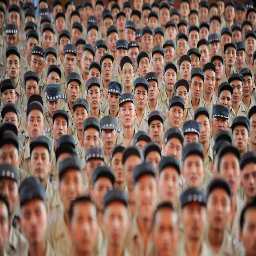

In [ ]:
imagen_crowd

In [ ]:
filas = int(np.ceil(np.sqrt(len(trozos))))
columnas = int(np.ceil(len(trozos) / filas))

personas_foto = 0

plt.figure(figsize=(15, 15))
for i, trozo in enumerate(trozos, 1):
    ax = plt.subplot(filas, columnas, i)
    ev_modelo = model(trozo)
    imprimir_objetos_multiple(trozo, ev_modelo)
    personas_foto = personas_foto + cantidad_personas(ev_modelo)

print(f'El total calculado de personas en la imagen es: {personas_foto}')
print(f'El total real de personas en la imagen es: {personas_real}')

In [ ]:
imagen_tf = tf.keras.preprocessing.image.load_img('/content/gdrive/MyDrive/Colab Notebooks/ProyectoFinal/Crowd Counting/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/Crowd/IMG_105.jpg')

In [ ]:
imagen_np = tf.keras.preprocessing.image.img_to_array(imagen_tf)

In [ ]:
# Imagen que se desea dividir
imagen_crowd = Image.fromarray(imagen_np.astype('uint8'))
print(imagen_crowd.size)
personas_real = number_list[7]

# Tamaño de los trozos
tamaño_trozos = (200, 200)

# Obtiene los trozos de la imagen
trozos = dividir_imagen(imagen_crowd, tamaño_trozos)

# Muestra cada trozo individualmente
for i, trozo in enumerate(trozos):
    trozo.show()

(990, 632)


In [ ]:
filas = int(np.ceil(np.sqrt(len(trozos))))
columnas = int(np.ceil(len(trozos) / filas))

personas_foto = 0

plt.figure(figsize=(15,15))
for i, trozo in enumerate(trozos, 1):
    ax = plt.subplot(3, 4, i)
    ev_modelo = model(trozo)
    imprimir_objetos_multiple(trozo, ev_modelo)
    personas_foto = personas_foto + cantidad_personas(ev_modelo)

print(f'El total calculado de personas en la imagen es: {personas_foto}')
print(f'El total real de personas en la imagen es: {personas_real}')

In [ ]:
# Imagen que se desea dividir
imagen_crowd = Image.fromarray(imagen_np.astype('uint8'))
print(imagen_crowd.size)
personas_real = number_list[7]

# Tamaño de los trozos
tamaño_trozos = (330, 126)

# Obtiene los trozos de la imagen
trozos = dividir_imagen(imagen_crowd, tamaño_trozos)

# Muestra cada trozo individualmente
for i, trozo in enumerate(trozos):
    trozo.show()

(990, 632)


In [ ]:
filas = int(np.ceil(np.sqrt(len(trozos))))
columnas = int(np.ceil(len(trozos) / filas))

personas_foto = 0

plt.figure(figsize=(15,15))
for i, trozo in enumerate(trozos, 1):
    ax = plt.subplot(5, 3, i)
    ev_modelo = model(trozo)
    imprimir_objetos_multiple(trozo, ev_modelo)
    personas_foto = personas_foto + cantidad_personas(ev_modelo)

print(f'El total calculado de personas en la imagen es: {personas_foto}')
print(f'El total real de personas en la imagen es: {personas_real}')

Con mejor resolución el resultado mejora considerablemente. Queda faltando entrenar el modulo con un dataset unicamente compuesto por personas, seguramente los resultados serian mucho mejores